In [1]:
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()
oscs = [fpga.osc(ch, 1.0) for ch in range(2)]

triggered


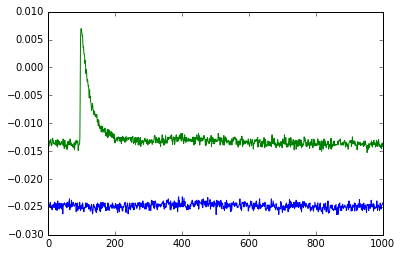

ctl_sts = 0x0000000c =         12  # control/status        
cfg_evn = 0x00000002 =          2  # SW event source select
cfg_trg = 0x00000008 =          8  # HW trigger mask       

cfg_pre = 0x00001000 =       4096  # delay pre  trigger        
cfg_pst = 0x00003000 =      12288  # delay post trigger        
sts_pre = 0x03e32448 =   65217608  # status pre  trigger       
sts_pst = 0x00003000 =      12288  # status post trigger       

cfg_neg = 0x-0000147 =       -327  # negative level     
cfg_pos = 0x-0000147 =       -327  # positive level     
cfg_edg = 0x00000000 =          0  # edge (0-pos, 1-neg)

cfg_dec = 0x00000000 =          0  # decimation factor
cfg_shr = 0x00000000 =          0  # shift right      
cfg_avg = 0x00000000 =          0  # average enable   
cfg_byp = 0x00000000 =          0  # bypass           
cfg_faa = 0x00007d93 =      32147  # AA coeficient    
cfg_fbb = 0x000437c7 =     276423  # BB coeficient    
cfg_fkk = 0x00d9999a =   14260634  # KK coeficient    
cfg_f

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

size = oscs[0].buffer_size
channels = (0, 1)
for ch in oscs:
    # data rate decimation 
    ch.decimation = 1
    
    # trigger timing [sample periods]
    N = ch.buffer_size
    ch.trigger_pre  = N//4*1
    ch.trigger_post = N//4*3
    
    ch.sync_src = fpga.sync_src["osc0"]
    ch.trig_src = fpga.trig_src["osc1"]
    ch.level = [-0.01, -0.01]
    ch.edge  = 'pos'
    
oscs[0].reset()
oscs[1].reset()
oscs[0].start()
oscs[1].start()
while (oscs[0].status_run()): pass
print('triggered')
buff = [oscs[ch].data(size) for ch in channels];
plt.plot(buff[0][4000:5000])
plt.plot(buff[1][4000:5000])
plt.show()

print(oscs[0].show_regset())

In [ ]:
#Setup realtime monitoring system
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool, Range1d
from bokeh.plotting import figure
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

x = np.arange(size)
colors = ('red', 'blue')
hover = HoverTool(mode = 'vline', tooltips=[("T", "@x"), ("V", "@y")])
tools = "pan,wheel_zoom,box_zoom,reset,crosshair"
p = figure(plot_height=500, plot_width=900, title="oscilloscope", toolbar_location="above", tools=(tools, hover))
p.xaxis.axis_label='time [s]'
p.yaxis.axis_label='voltage [V]'
p.y_range=Range1d(-1.2, 1.2)
r = [p.line(x, buff[i], line_width=1, line_alpha=0.7, color=colors[i]) for i in channels]
target = show(p, notebook_handle=True)

In [ ]:
#Define the double trigger
def checkThresh(iD,iVal):
    #res = list(map(lambda i: i> iVal, iD))
    res=np.argwhere(iD > iVal)
    res1=[]
    if len(res) > 0:
        res1.append(res[0])
        old  = res1[0]
        for pVal in res:
            if pVal < old+20:
                old = pVal
                continue
            res1.append(pVal)
            old = pVal
    return res1
    
def doublePulse(iD,iVal,dMin=0.001):
    res=checkThresh(iD,iVal)
    if len(res)  < 2:
        return -1
    if iD[int(res[-1])+2] < iVal:
        return -1
    minimum=np.min(iD[int(res[0]):int(res[-1])])
    baseline=np.average(iD[0:3000])
    if abs(minimum-baseline) > dMin:
        return -1
    return (res[-1]-res[0])

def checkAll(iD0,iVal0,iD1,iVal1):
    val0=doublePulse(iD0,iVal0)
    val1=doublePulse(iD1,iVal1)
    if val0 > 0: 
        print("Double Pulse 0: ",val0)
        return val0
    if val1 > 0: 
        print("Double Pulse 1: ",val1)
        return val1
    val0s=checkThresh(iD0,iVal0)
    val1s=checkThresh(iD1,iVal1)
    if len(val0s) > 0 and len(val1s) > 0 and abs(val0s[0]-val1s[0]) > 0 and abs(val0s[0]- val1s[0]) < 200000 :
        print("2 DW Events",abs(val0s[0]- val1s[0]))
        return abs(val0s[0]- val1s[0])
    return -1

In [ ]:
#Continuously run reading the trigger and writing to text events that pass the trigger
while True:
    oscs[0].reset()
    oscs[1].reset()
    oscs[0].start()
    oscs[1].start()
    while oscs[1].status_run(): pass
    buff = [oscs[ch].data(size) for ch in channels];
    dt=checkAll(buff[0],-0.022,buff[1],-0.011)
    #val0=checkThresh(buff[0],-0.022)
    #val1=checkThresh(buff[1],-0.011)
    if dt > 0:
        with open('synch.txt', 'a+') as f:
            for item in buff[0]:
                f.write("%s," % item)
            f.write("\t\t\t" % item)
            for item in buff[1]:
                f.write("%s," % item)
            f.write("\n" % item)
        for i in channels:
            r[i].data_source.data['y'] = buff[i]
    push_notebook(handle=target)